# Homework 1 - Professionalism & Reproducibility
### DATA 512 - Human-Centered Data Science
#### Aamir Darukhanawalla

#### Import the required libraries

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

import requests
import time
import urllib

#### Read the list of dinosaur articles from the below excel file

In [2]:
DINOSAUR_FILE = 'Data/dinosaur_genera.cleaned.SEPT.2022.xlsx'
dinosaur_list = pd.read_excel(DINOSAUR_FILE)

#### Set constants for the Pageviews API call

In [3]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0) - API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': 'aamird@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = dinosaur_list['name']

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",
    "agent":       "user",
    "article":     "",
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022100100"
}

#### Call the Pageviews API and return the JSON response

In [4]:
def request_pageviews_per_article(article_title = None,
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # Make sure we have an article title
    if not article_title: return None

    # Make sure we have the access type
    if not access_type: return None

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access_type

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url + endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

#### Convert the JSON API response into a Pandas DataFrame

In [5]:
def get_dataframe_for_access_type(access_type):
    # Make sure we have a valid access type
    if access_type not in ('desktop', 'mobile-app', 'mobile-web'): return None
    return pd.DataFrame([
        month for article in ARTICLE_TITLES for month in request_pageviews_per_article(article, access_type)['items']]
    ).drop('access', axis=1)

#### Get the respective Pandas DataFrames for the 'desktop', 'mobile-app', and 'mobile-web' access type.

In [6]:
df_desktop = get_dataframe_for_access_type('desktop')
df_mobile_app = get_dataframe_for_access_type('mobile-app')
df_mobile_web = get_dataframe_for_access_type('mobile-web')

#### Calculate combines views for all mobile access types

In [ ]:
df_mobile = df_mobile_app.copy()
df_mobile['views'] = df_mobile_app['views'] + df_mobile_web['views']

#### Calculate the cumulative views for all access types

In [33]:
df_cumulative = df_desktop.copy()
df_cumulative['views'] = df_desktop['views'] + df_mobile['views']
df_cumulative['views'] = df_cumulative.groupby('article')['views'].cumsum()

#### Save the respective JSON files

In [200]:
json_dir = 'JSON'
start_date = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['start']
end_date = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['end']
df_desktop.to_json('{}/dino_monthly_{}_{}-{}.json'.format(json_dir, 'desktop', start_date, end_date), orient='records', indent=2)
df_mobile.to_json('{}/dino_monthly_{}_{}-{}.json'.format(json_dir, 'mobile', start_date, end_date), orient='records', indent=2)
df_cumulative.to_json('{}/dino_monthly_{}_{}-{}.json'.format(json_dir, 'cumulative', start_date, end_date), orient='records', indent=2)

#### Subset data for articles, views and timestamp

In [201]:
def df_to_time_series(df):
    ts = df[['article', 'views']]
    ts['date'] = pd.to_datetime(df['timestamp'].astype(str), format='%Y%m%d%H')
    ts.set_index('date', inplace=True)
    return ts

In [202]:
ts_desktop = df_to_time_series(df_desktop)
ts_mobile = df_to_time_series(df_mobile)

C:\Users\aamir\AppData\Local\Temp\ipykernel_18244\2205098888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['date'] = pd.to_datetime(df['timestamp'].astype(str), format='%Y%m%d%H')
C:\Users\aamir\AppData\Local\Temp\ipykernel_18244\2205098888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['date'] = pd.to_datetime(df['timestamp'].astype(str), format='%Y%m%d%H')


#### Maximum Average and Minimum Average
The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

In [203]:
def get_time_series(access_type, minmax):

    if access_type == 'desktop':
        df = ts_desktop
    elif access_type == 'mobile':
        df = ts_mobile
    else:
        raise ValueError('Invalid access type.')

    article_mean_views = df.groupby('article')['views'].mean()

    if minmax == 'max':
        article = article_mean_views.idxmax()
    elif minmax == 'min':
        article = article_mean_views.idxmin()
    else:
        raise ValueError('Invalid value for minmax.')

    ts = df[df['article'] == article]['views']
    ts.rename('{} {} ({})'.format(access_type.capitalize(), minmax.capitalize(), article), inplace=True)
    return ts

In [204]:
ts_desktop_mobile_min_max = pd.concat([
    get_time_series('desktop', 'max'),
    get_time_series('desktop', 'min'),
    get_time_series('mobile', 'max'),
    get_time_series('mobile', 'min')
], axis=1)

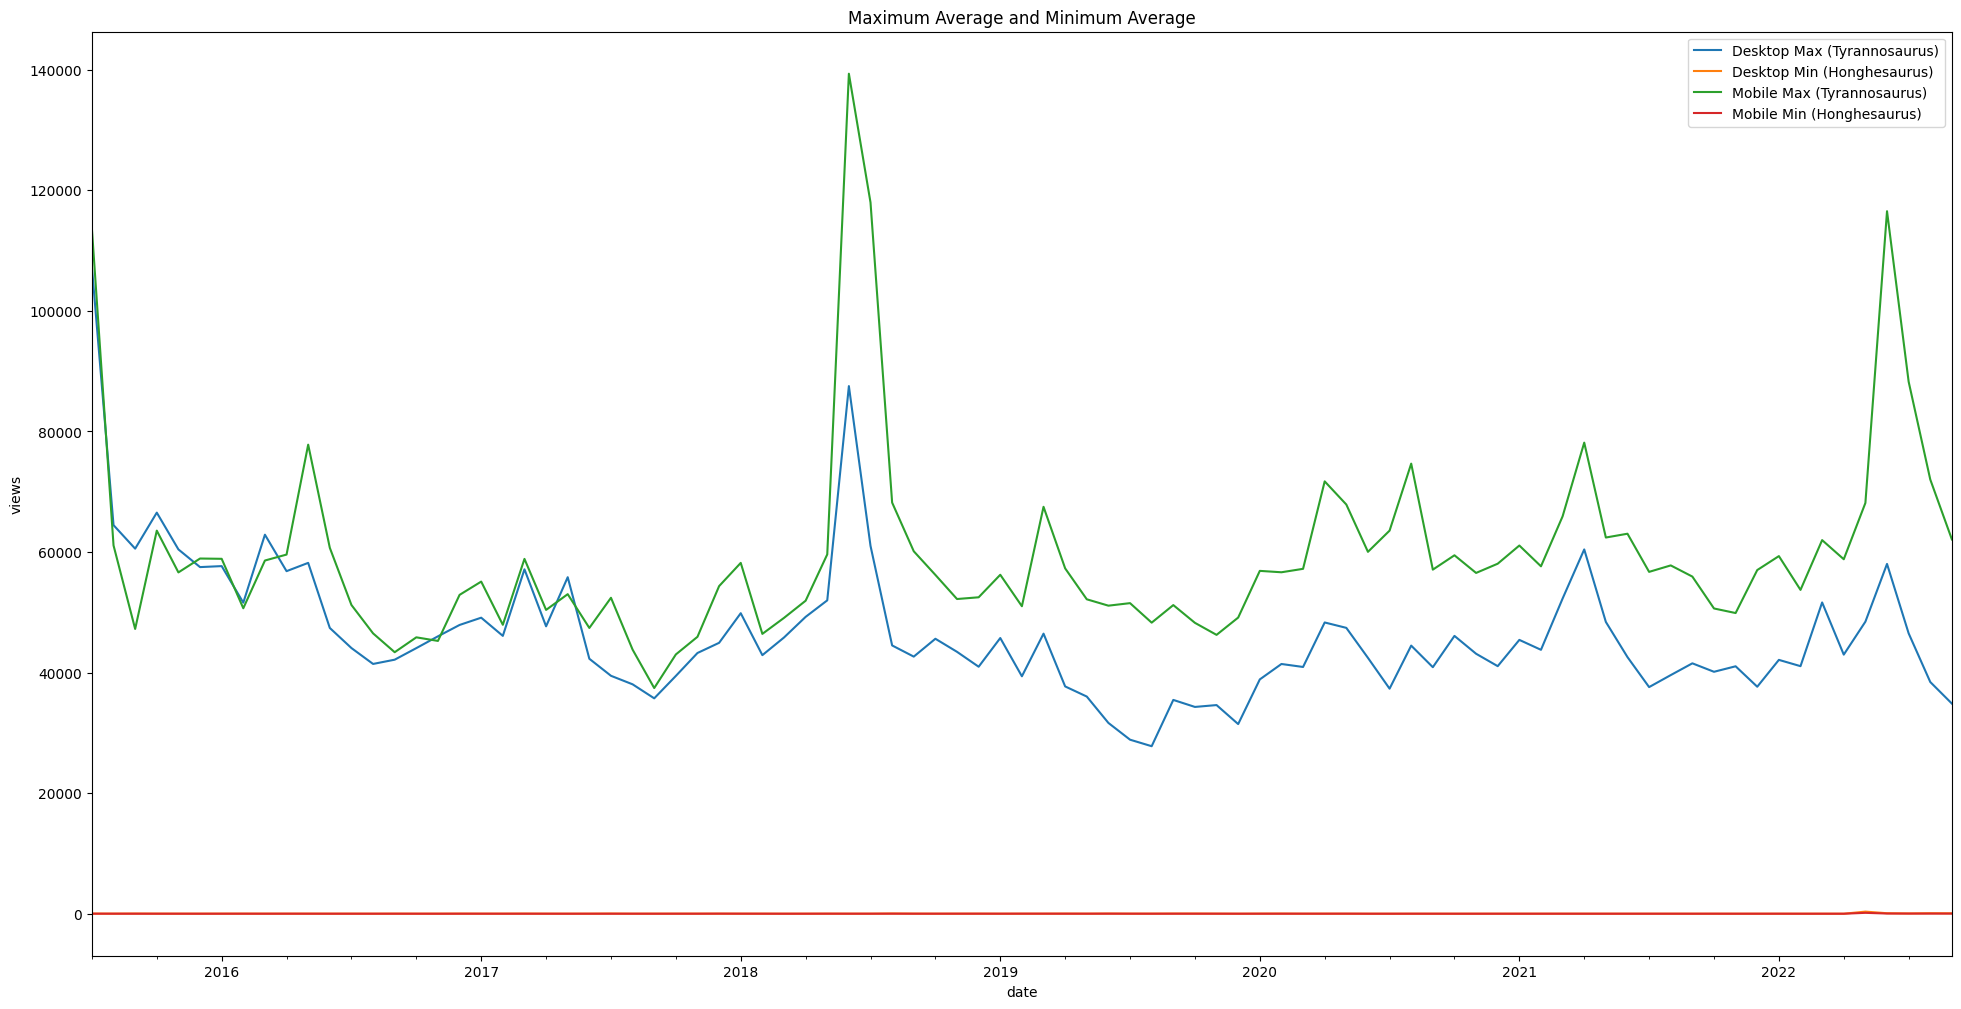

In [205]:
plot_dir = 'Plots'
title = 'Maximum Average and Minimum Average'
ts_desktop_mobile_min_max.plot(ylabel='views', title=title)
plt.savefig('{}/{}.png'.format(plot_dir, title))

In [206]:
ts_desktop['article'] = ts_desktop['article'] + ' (Desktop)'
ts_mobile['article'] = ts_mobile['article'] + ' (Mobile)'

C:\Users\aamir\AppData\Local\Temp\ipykernel_18244\2153655199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_desktop['article'] = ts_desktop['article'] + ' (Desktop)'
C:\Users\aamir\AppData\Local\Temp\ipykernel_18244\2153655199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_mobile['article'] = ts_mobile['article'] + ' (Mobile)'


#### Top 10 Peak Page Views
The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

In [207]:
ts_desktop_peaks = ts_desktop[ts_desktop['article'].isin(ts_desktop.groupby('article')['views'].max().nlargest(10).index)]
ts_mobile_peaks = ts_mobile[ts_mobile['article'].isin(ts_mobile.groupby('article')['views'].max().nlargest(10).index)]

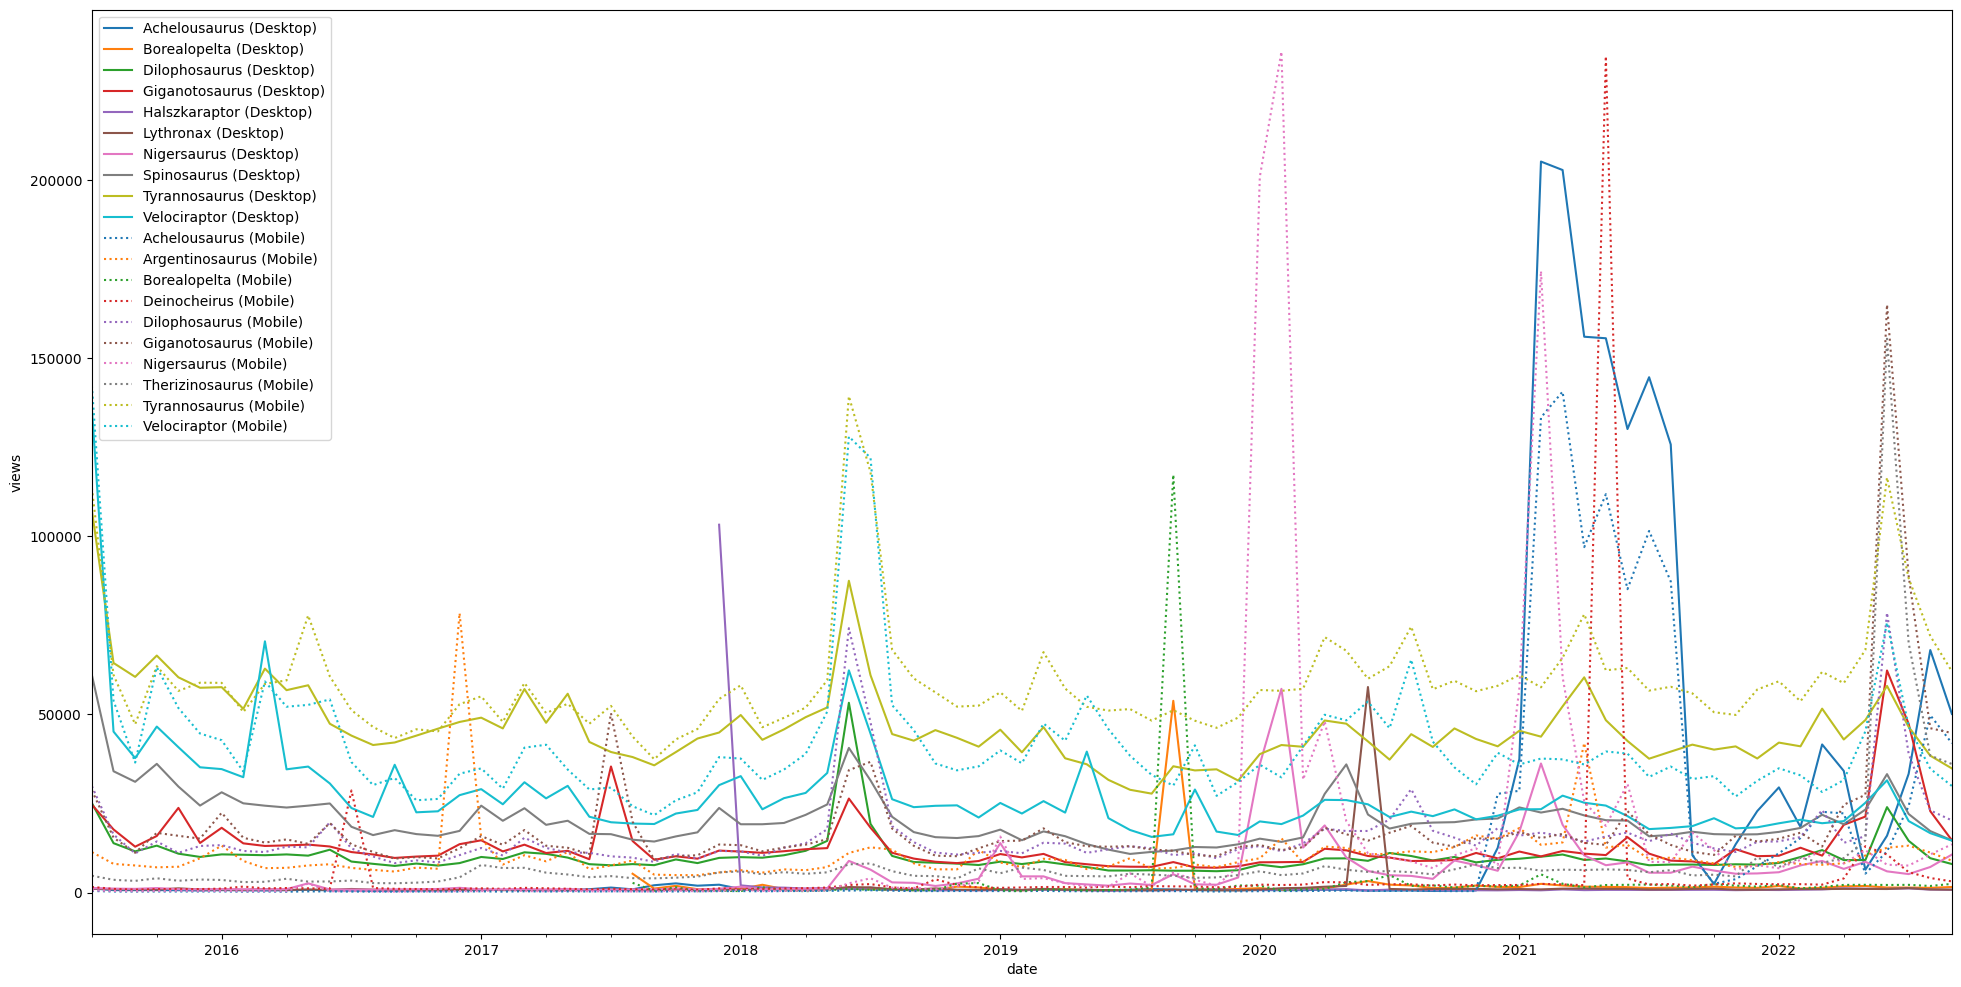

In [208]:
plt.rcParams['figure.figsize'] = (24, 12)
ts_desktop_peaks.groupby('article')['views'].plot(legend=True, ylabel='views')
ts_mobile_peaks.groupby('article')['views'].plot(legend=True, style=':')

title = 'Top 10 Peak Page Views'
plt.savefig('{}/{}.png'.format(plot_dir, title))

#### Fewest Months of Data
The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

In [209]:
ts_desktop_counts = ts_desktop[ts_desktop['article'].isin(ts_desktop.groupby('article').size().nsmallest(10).index)]
ts_mobile_counts = ts_mobile[ts_mobile['article'].isin(ts_mobile.groupby('article').size().nsmallest(10).index)]

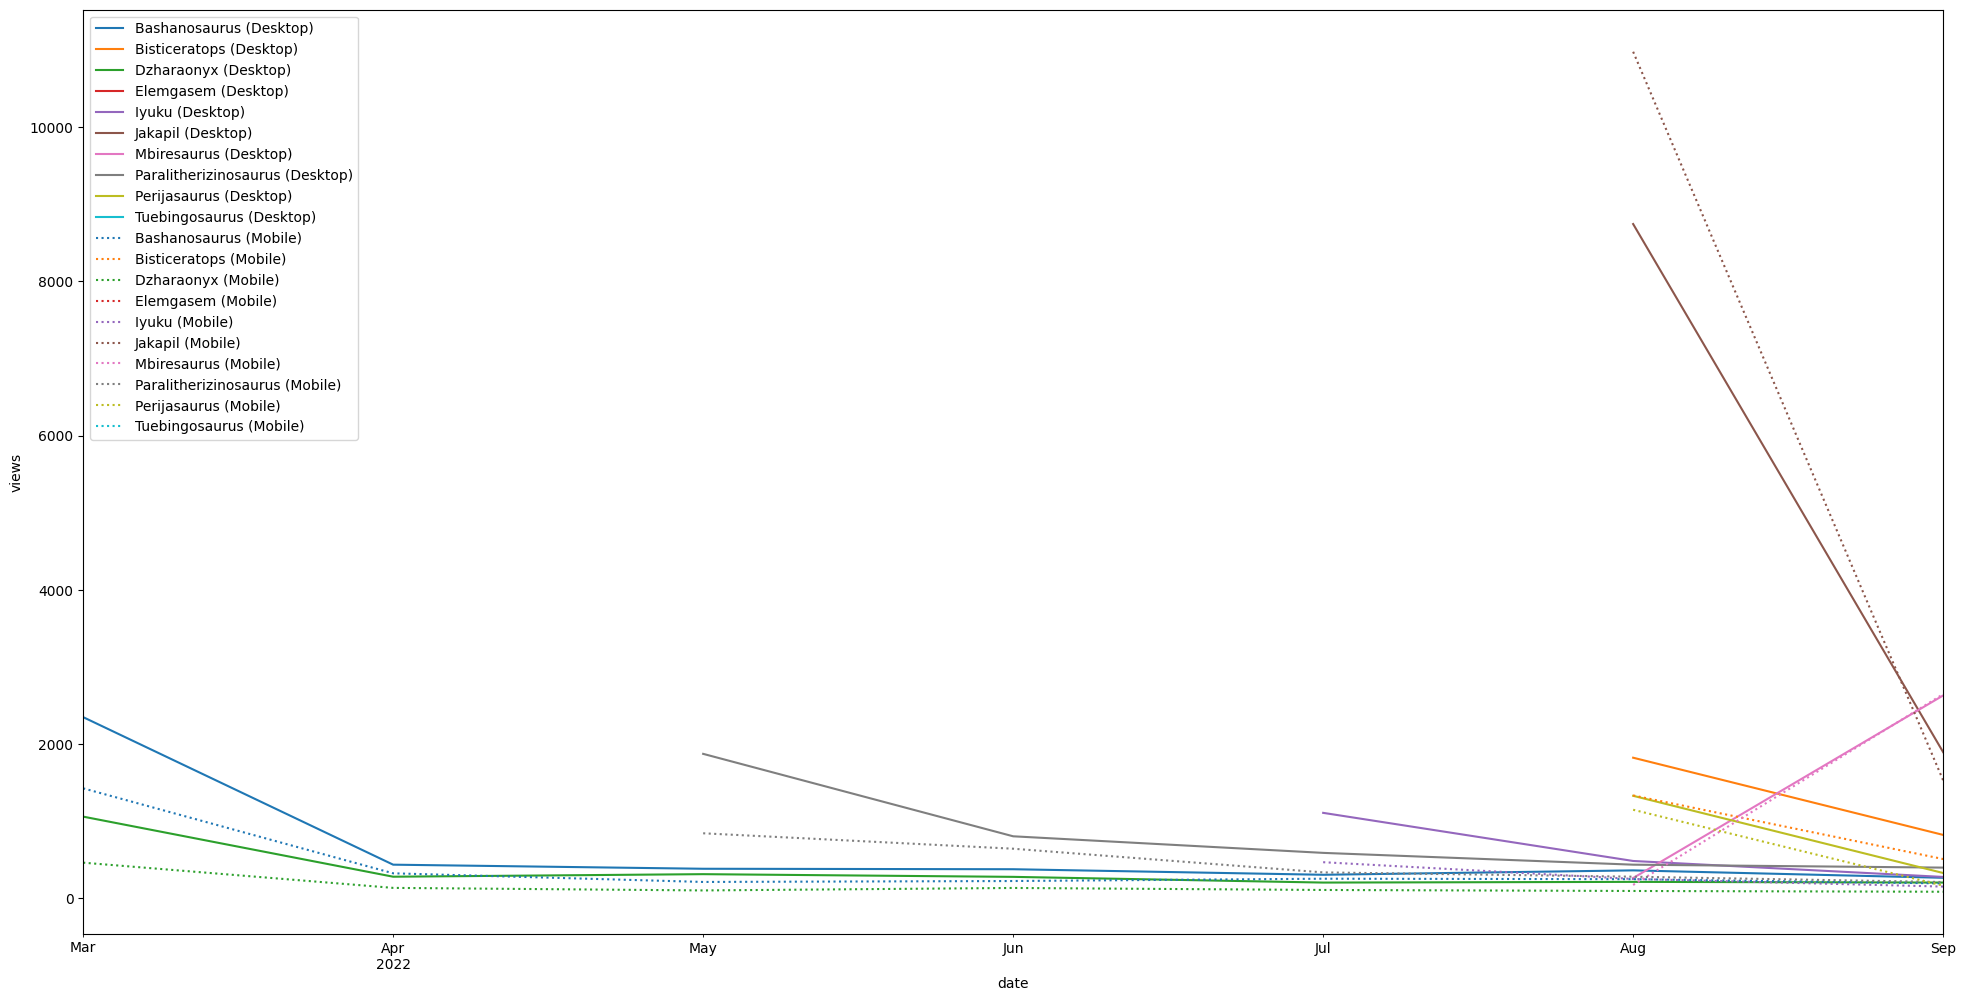

In [210]:
plt.rcParams['figure.figsize'] = (24, 12)
ts_desktop_counts.groupby('article')['views'].plot(legend=True, ylabel='views')
ts_mobile_counts.groupby('article')['views'].plot(legend=True, style=':')

title = 'Fewest Months of Data'
plt.savefig('{}/{}.png'.format(plot_dir, title))